# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#DummyClassifier" data-toc-modified-id="DummyClassifier-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>DummyClassifier</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#Выбор-модели" data-toc-modified-id="Выбор-модели-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Выбор модели</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import re

import spacy
nlp = spacy.load("en_core_web_sm")

from pymystem3 import Mystem

import nltk
nltk.download('punkt_tab')

nltk.download('stopwords')
from nltk.corpus import stopwords
stoplist = stopwords.words('english')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import Pool, CatBoostClassifier, cv
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_auc_score

import torch
import transformers
from tqdm import notebook

[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Подготовка

In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
df.isnull().sum()

text     0
toxic    0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
'''
lemmatizer = WordNetLemmatizer()
def clear_text(text):
    clean_text = " ".join(re.sub(r'[^a-zA-Z]', ' ', text).lower().split())
    word_list = nltk.word_tokenize(clean_text, language="english")
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

df['lemmatized'] = df['text'].apply(clear_text)
'''

'\nlemmatizer = WordNetLemmatizer()\ndef clear_text(text):\n    clean_text = " ".join(re.sub(r\'[^a-zA-Z]\', \' \', text).lower().split())\n    word_list = nltk.word_tokenize(clean_text, language="english")\n    lemmatized_output = \' \'.join([lemmatizer.lemmatize(w) for w in word_list])\n    return lemmatized_output\n\ndf[\'lemmatized\'] = df[\'text\'].apply(clear_text)\n'

In [9]:
from tqdm.notebook import tqdm
tqdm.pandas()

def clean_text(text):
    clean = nlp(" ".join(re.sub(r'[^a-zA-z]', ' ', text).split()), disable = ['ner', 'parser'])
    lemmatized_output = ' '.join([w.lemma_ for w in clean])
    return lemmatized_output

df['spacy_lemmatize'] = df['text'].progress_apply(clean_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

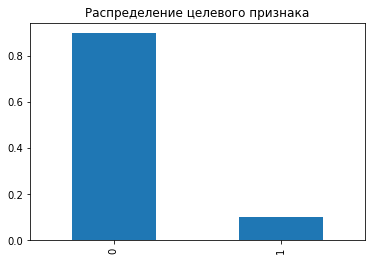

In [10]:
df['toxic'].value_counts(normalize=(0,1)).plot(kind='bar', title='Распределение целевого признака');

Видим дисбаланс классов: количество объектов нулевого класса превышает практически в 9 раз.

In [11]:
X = df.drop(['toxic'], axis=1)
y = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

print(X_train.shape)
print(X_test.shape)

(143362, 2)
(15930, 2)


In [12]:
X_train

,text,spacy_lemmatize
22605,"""\n\nPlease stop. If you continue to vandalize...",please stop if you continue to vandalize page ...
150502,"""\n\n Your Chanology """"nonviolence"""" comment \...",your Chanology nonviolence comment you say tha...
17008,", All the changes in which the Species Abbrevi...",all the change in which the Species Abbreviati...
51716,"""::: """"Red-headed boys blonde girls tease teas...",red head boy blonde girl tease tease brunette ...
51973,Britain in need \nHelp stop islam in Britain v...,Britain in need Help stop islam in Britain vot...
...,...,...
104782,"I identified myself and gave reasoning, which ...",I identify myself and give reasoning which be ...
94439,That's pretty disingenuous. Erik's clever eno...,that s pretty disingenuous Erik s clever enoug...
107783,"""\n """"She attended the Wellesley in Washington...",she attend the Wellesley in Washington program...
94548,"Abraham de Vries (minister) \n\nHi Jane,\n\nTh...",Abraham de Vries minister hi Jane thank a lot ...


In [13]:
corpus_train = X_train['spacy_lemmatize'].values
corpus_test = X_test['spacy_lemmatize'].values

count_tf_idf = TfidfVectorizer(stop_words=stoplist)

tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_test = count_tf_idf.transform(corpus_test)

print(tf_idf_train.shape)
print(tf_idf_test.shape)

(143362, 150494)
(15930, 150494)


## Обучение

In [19]:
scoring = {"F1": "f1", "AUC": "roc_auc"}

### DummyClassifier

In [20]:
cv_results = cross_validate(DummyClassifier(strategy='stratified'), tf_idf_train, y_train, cv=5, scoring=scoring)
info_DC = [cv_results['test_F1'].mean(), cv_results['test_AUC'].mean()]

### LogisticRegression

In [21]:
pipeline_LR = Pipeline(
[
        ("vect", TfidfVectorizer(stop_words=stoplist)),
        ("clf", LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=100)),
    ]
)

In [22]:
grid_values_LR = {
    "vect__norm": ("l1", "l2"),
    "clf__C": [0.001, 0.01, 0.1, 1, 5, 10],
}

In [23]:
model_LR = RandomizedSearchCV(
    estimator=pipeline_LR, 
    cv=5,
    scoring=scoring, 
    param_distributions=grid_values_LR,
    return_train_score=True,
    refit="F1")

model_LR.fit(corpus_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(stop_words=['i',
                                                                          'me',
                                                                          'my',
                                                                          'myself',
                                                                          'we',
                                                                          'our',
                                                                          'ours',
                                                                          'ourselves',
                                                                          'you',
                                                                          "you're",
                                                                          "you've",
                   

In [24]:
info_LR = [model_LR.cv_results_['mean_train_F1'].mean(), model_LR.cv_results_['mean_train_AUC'].mean()]

### DecisionTreeClassifier

In [25]:
pipeline_DT = Pipeline(
[
        ("vect", TfidfVectorizer(stop_words=stoplist)),
        ("clf", DecisionTreeClassifier(random_state=42)),
    ]
)

In [26]:
grid_values_DT = {
    "vect__norm": ("l1", "l2"),
    "clf__max_depth": range(5, 10), 
    "clf__max_features": range(5, 10)
}

In [27]:
model_DT = RandomizedSearchCV(
    estimator=pipeline_DT, 
    cv=5,
    n_iter=12,
    scoring=scoring, 
    param_distributions=grid_values_DT,
    return_train_score=True,
    refit="F1")

model_DT.fit(corpus_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(stop_words=['i',
                                                                          'me',
                                                                          'my',
                                                                          'myself',
                                                                          'we',
                                                                          'our',
                                                                          'ours',
                                                                          'ourselves',
                                                                          'you',
                                                                          "you're",
                                                                          "you've",
                   

In [28]:
info_DT = [model_DT.cv_results_['mean_train_F1'].mean(), model_DT.cv_results_['mean_train_AUC'].mean()]

### Выбор модели

In [29]:
result = pd.DataFrame(data=[info_DC, info_LR, info_DT], 
                      index=["DummyClassifier", "LogisticRegression", "DecisionTreeClassifier"], 
                      columns=["f1_score", "ROC-AUC"])
result.sort_values('f1_score', ascending=False)

,f1_score,ROC-AUC
LogisticRegression,0.754754,0.964491
DummyClassifier,0.099211,0.501708
DecisionTreeClassifier,0.002251,0.501292


In [30]:
model_LR.best_estimator_

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('clf', LogisticRegression(C=10, class_weight='balanced'))])

## Выводы

In [39]:
y_pred = model_LR.predict(corpus_test)
print("F1: ", round(f1_score(y_test, y_pred), 2))
print("ROC-AUC: ", round(roc_auc_score(y_test, y_pred), 2))

F1:  0.77
ROC-AUC:  0.9


- Подобрана лучшая модель: **LogisticRegression(C=10, class_weight='balanced')**
- На тестовой выборке результат: f1 = 0.77; ROC-AUC = 0.9
- На кросс-валидации лучший результат: f1 = 0.75; ROC-AUC = 0.96
- Рассматривались три модели: DummyClassifier, LogisticRegression, DecisionTreeClassifier
- Подбор параметров производился с помощью RandomizedSearchCV
- Предварительно была проведена предобработка данных:
    - Проверка на дубликаты
    - Проверка на пропуски
    - Проверка на соответствие типам данных
- Изначальный текст был подготовлен к обучению моделей:
    - Текст переведен в нижний регистр
    - Удалены лишние символы
    - Проведена лемматизация и токкенизация с помощью spacy
    - Выявлен дисбаланс классов